In [1]:
import os
os.chdir(os.path.expanduser('~/My Drive/dirclip-private/core'))

In [2]:
import operator as op
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
from scipy.ndimage import gaussian_filter1d
from functools import partial
from jax import vmap
from jax.tree_util import tree_map, tree_leaves, tree_reduce
from jax.lax import fori_loop
from jax.flatten_util import ravel_pytree
import utils

In [3]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

# HMC sampler

In [4]:
def r_hat(y, eps=1e-12):
    """
    the R hat metric measures how well an MCMC chain "mixes"
    Based on the paper "What Are Bayesian Neural Network Posteriors Really Like? - Appendix B"
    y.shape: [num_chains (M) x num_steps (N) x num_features (B)]
    """
    M, N, B = y.shape

    # compute variances
    b = (N/(M-1)) * ((y.mean(axis=1, keepdims=True) - y.mean(axis=(0, 1), keepdims=True))**2).sum(axis=(0, 1))
    w = 1/(M*(N-1)) * ((y - y.mean(axis=1, keepdims=True))**2).sum(axis=(0, 1))
    
    # avoid division by zero
    b += eps
    w += eps
    
    # get r hat
    r_hat = jnp.sqrt((((N-1)/N)*w + (1/N)*b)/w)
    
    return r_hat

In [5]:
def ifelse(cond, val_true, val_false):
    return jax.lax.cond(cond, lambda x: x[0], lambda x: x[1], (val_true, val_false))

def leapfrog(params, momentum, log_prob_fn, step_size, n_steps):
    """Approximates Hamiltonian dynamics using the leapfrog algorithm."""

    # define a single step
    def step(i, args):
        params, momentum = args

        # update momentum
        grad = jax.grad(log_prob_fn)(params)
        momentum = tree_map(lambda m, g: m + 0.5 * step_size * g, momentum, grad)

        # update params
        params = tree_map(lambda p, m: p + m * step_size, params, momentum)

        # update momentum
        grad = jax.grad(log_prob_fn)(params)
        momentum = tree_map(lambda m, g: m + 0.5 * step_size * g, momentum, grad)

        return params, momentum

    # do 'n_steps'
    new_params, new_momentum = fori_loop(0, n_steps, step, (params, momentum))

    return new_params, new_momentum

def hmc_sample(key, params_init, log_prob_fn, step_size, n_leapfrog_steps=10_000, n_steps=100, burn_frac=0.3, n_chains=3):
    """
    Runs HMC and returns the full Markov chain as a list.
    - params: array
    - log_prob_fn: function that takes params as the only argument and returns a scalar value
    """

    # define a single step
    @jax.jit
    def step_fn(carry, x):
        params, key = carry
        key, normal_key, uniform_key = jax.random.split(key, 3)

        # generate random momentum
        momentum = utils.normal_like_tree(key, params)

        # leapfrog
        new_params, new_momentum = leapfrog(params, momentum, log_prob_fn, step_size, n_leapfrog_steps)

        # MH correction
        potentaial_energy_diff = log_prob_fn(new_params) - log_prob_fn(params)
        momentum_dot = tree_reduce(op.add, tree_map(lambda x: (x**2).sum(), tree_leaves(momentum)))
        new_momentum_dot = tree_reduce(op.add, tree_map(lambda x: (x**2).sum(), tree_leaves(new_momentum)))
        kinetic_energy_diff = 0.5*(momentum_dot - new_momentum_dot)
        log_accept_prob = potentaial_energy_diff + kinetic_energy_diff
        log_accept_prob = jnp.nan_to_num(log_accept_prob, nan=-jnp.inf)
        accept_prob = jnp.minimum(1, jnp.exp(log_accept_prob))
        accept = jax.random.uniform(uniform_key) < accept_prob
        params = ifelse(accept, new_params, params)

        return (params, key), (params, accept_prob)

    # sample multiple chains
    def sample(key):
        # do 'n_steps' (compiled)
        _, (chain, accept_prob) = jax.lax.scan(step_fn, (params_init, key), xs=None, length=n_steps)
        return chain, accept_prob
    keys = jax.random.split(key, n_chains)
    chains, accept_prob = vmap(sample)(keys)
    
    # burn-in
    n_burn = int(burn_frac*n_steps) # number of burn-in steps
    chains = tree_map(lambda leaf: leaf[:, n_burn:], chains)
    
    # get accuracy
    logits = vmap(vmap(lambda params: predict_fn(params, x)))(chains)
    y_hat = jax.nn.softmax(logits)
    acc = (y_hat.argmax(-1) == y).mean()
    
    # r-hat
    flatten_fn = lambda tree: ravel_pytree(tree)[0]
    chain_flat = vmap(vmap(flatten_fn))(chains) # [n_chains, n_steps, n_params]
    r_ps = r_hat(chain_flat).mean() # parameter-space
    r_fs = r_hat(y_hat[..., 0]).mean() # function-space
    
    print(f'accept={accept_prob.mean():.2%}, {r_ps=:.2f}, {r_fs=:.2f}, {acc=:.2%}')
    return chains

# Model

In [6]:
# define a simple MLP
def make_mlp(key, in_dim: int, out_dim: int, hidden_dims: list[int], init_std: float = 1):
    
    # initialize parameters
    layer_dims = [in_dim, *hidden_dims, out_dim]
    ws, bs = [], []
    for i in range(1, len(layer_dims)):
        key, kw, kb = jax.random.split(key, 3)
        in_dim = layer_dims[i-1]
        out_dim = layer_dims[i]
        ws += [init_std * jax.random.normal(kw, [out_dim, in_dim])]
        bs += [init_std * jax.random.normal(kb, [out_dim])]
    params = (ws, bs)
    
    # make forward function
    # @jax.jit
    @partial(vmap, in_axes=(None, 0))
    def forward(params, x):
        ws, bs = params
        for w, b in zip(ws[:-1], bs[:-1]):
            x = jax.nn.relu(w @ x + b)
        x = ws[-1] @ x + bs[-1]
        return x
    
    return params, forward

key = jax.random.PRNGKey(0)
in_dim = 2
out_dim = 2
hidden_dims = 5*[10]
params_init, predict_fn = make_mlp(key, in_dim, out_dim, hidden_dims)
print('num. params:', sum(tree_map(jnp.size, tree_leaves(params_init))))

num. params: 492


# dataset

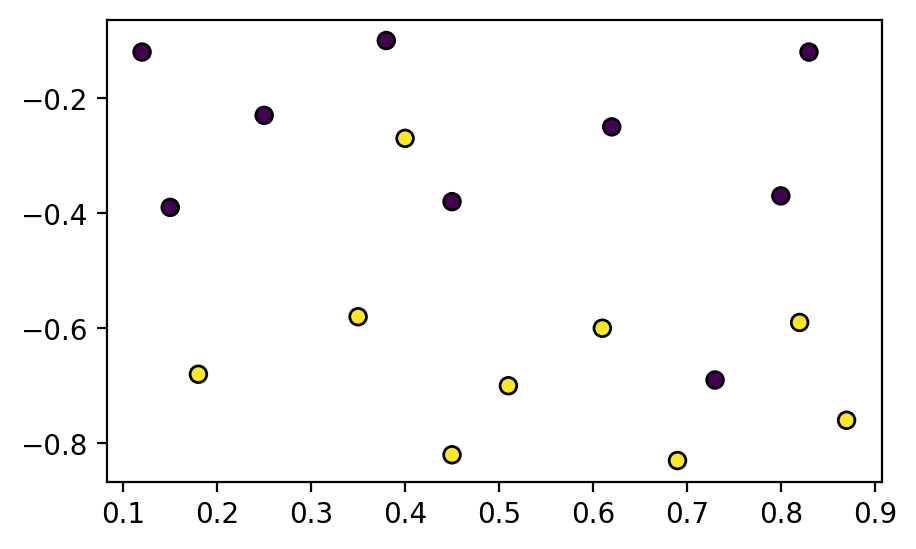

In [7]:
x = jnp.array([[0.15, -0.39], [0.25, -0.23], [0.12, -0.12], [0.38, -0.10], [0.45, -0.38], [0.62, -0.25], [0.83, -0.12], [0.80, -0.37], [0.73, -0.69], [0.18, -0.68], [0.35, -0.58], [0.45, -0.82], [0.51, -0.70], [0.61, -0.60], [0.69, -0.83], [0.87, -0.76], [0.82, -0.59], [0.40, -0.27]])
y = jnp.array(9*[0]+9*[1])
fig, ax = plt.subplots(figsize=(5, 3))
plt.scatter(*x.T, c=y, edgecolors='black')
plt.show()

# distributions

In [8]:
def log_posterior_fn(params, x, y, std=1, alpha=None, clip_logp=-50, T=1):
    log_posterior = 0
    
    # likelihood
    logits = predict_fn(params, x)
    _, n_class = logits.shape
    y_one_hot = jax.nn.one_hot(y, n_class)
    logprobs = jax.nn.log_softmax(logits)
    log_posterior += (logprobs * y_one_hot).sum()
    
    # normal prior
    if std is not None:
        dx = tree_reduce(op.add, tree_map(lambda x: (x**2).sum(), params))
        log_prior = -0.5 * dx / std**2
        log_posterior += log_prior
    
    # dirichlet prior
    if alpha is not None:
        logprobs_clipped = logprobs.clip(min=clip_logp)
        log_prior = ((alpha-1) * logprobs_clipped).sum()
        log_posterior += log_prior
    
    return log_posterior / T

## run HMC

In [9]:
key = jax.random.PRNGKey(0)

In [10]:
%%time
log_prob_fn = partial(log_posterior_fn, x=x, y=y, alpha=1.4)
chains_dir_hi = hmc_sample(key, params_init, log_prob_fn, 4e-4, n_steps=500)

accept=96.32%, r_ps=1.00, r_fs=1.00, acc=69.88%
CPU times: user 3min 24s, sys: 170 ms, total: 3min 24s
Wall time: 3min 24s


In [11]:
%%time
log_prob_fn = partial(log_posterior_fn, x=x, y=y, alpha=0.6)
chains_dir_lo = hmc_sample(key, params_init, log_prob_fn, 5e-5, n_steps=500)

accept=91.54%, r_ps=1.05, r_fs=1.00, acc=100.00%
CPU times: user 3min 24s, sys: 157 ms, total: 3min 24s
Wall time: 3min 25s


# plot predictions

In [12]:
%%time
%%capture
# compute decision boundaries
s = 400 # grid size
x0_min, x0_max = x[:, 0].min() - 0.1, x[:, 0].max() + 0.1
x1_min, x1_max = x[:, 1].min() - 0.1, x[:, 1].max() + 0.1
x0 = jnp.linspace(x0_min, x0_max, s)
x1 = jnp.linspace(x1_min, x1_max, s)
x_ = jnp.stack(jnp.meshgrid(x0, x1), -1)
x_ = x_.reshape(s*s, 2)
extent = (x0_min, x0_max, x1_min, x1_max)

boundaries = []
for chains in (chains_dir_hi, chains_dir_lo):
    chain = tree_map(jnp.concatenate, chains) # concatenate chains
    logits = jax.lax.map(lambda params: predict_fn(params, x_), chain)
    probs = jnp.exp(utils.average_predictions(logits))
    cs = plt.contour(probs[:, 0].reshape(s, s) > 0.5, extent=extent)
    boundaries += [cs.allsegs[0]]

CPU times: user 33.6 s, sys: 5.53 s, total: 39.1 s
Wall time: 14.2 s


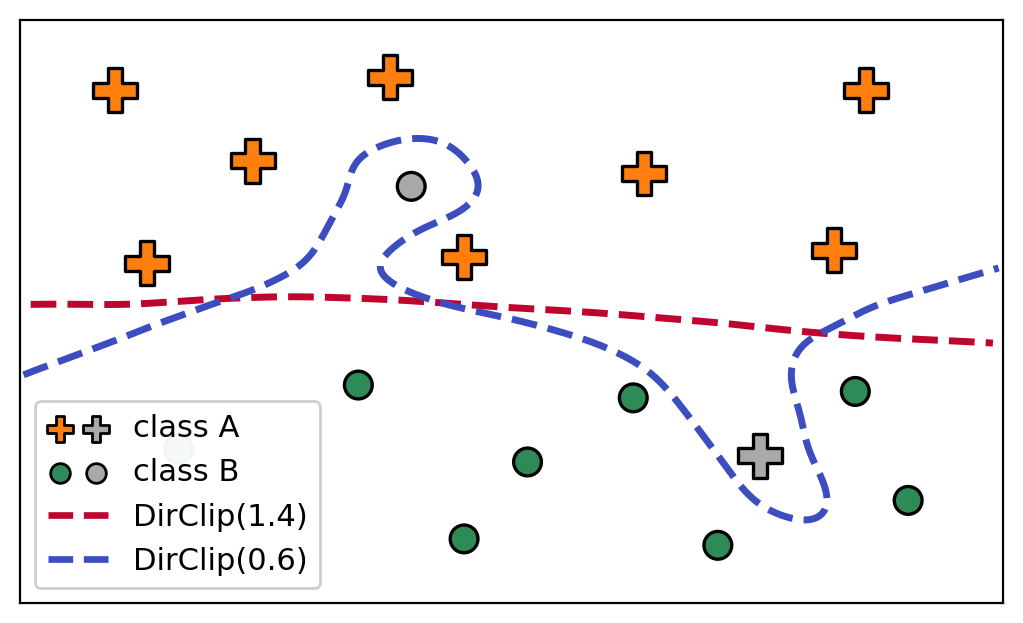

In [13]:
fig, ax = plt.subplots(figsize=(5, 3), layout='compressed')

# use same colors as NDG paper
# color_class1, color_class2, color_noise = '#ff7f2a', '#aa36c8', '#d30101'
# color_smooth, color_flexible = '#d30101', '#013280'

# set custom colors
color_class1, color_class2, color_noise = 'tab:orange', 'seagreen', 'darkgray'
color_smooth, color_flexible = (0.75, 0.02, 0.18), (0.23, 0.3, 0.75) # coolwarm red and blue

# plot data
ax.scatter(*x[y==0].T, c=8*[color_class1]+[color_noise], s=250, marker='P', edgecolors='black', linewidths=1.2)
ax.scatter(*x[y==1].T, c=8*[color_class2]+[color_noise], s=100, marker='o', edgecolors='black', linewidths=1.2)

# plot decision boundaries
# the decision boundaries are vety slightly smoothened to look less 'rough'
for dist_bounds, color in zip(boundaries, (color_smooth, color_flexible)):
    for line in dist_bounds:
        ax.plot(*gaussian_filter1d(line.T, 12), c=color, ls='--', lw=2.5)

# legend
# using blank plots to manually control the scatter point size and line width
class1_valid = plt.scatter([], [], color=color_class1, s=90, marker='P', edgecolors='black', linewidths=1)
class1_noise = plt.scatter([], [], color=color_noise,  s=90, marker='P', edgecolors='black', linewidths=1)
class2_valid = plt.scatter([], [], color=color_class2, s=50, marker='o', edgecolors='black', linewidths=1)
class2_noise = plt.scatter([], [], color=color_noise,  s=50, marker='o', edgecolors='black', linewidths=1)
line1, = ax.plot([], [], c=color_smooth,   ls='--', lw=2.4)
line2, = ax.plot([], [], c=color_flexible, ls='--', lw=2.4)
legend = ax.legend([(class1_valid, class1_noise), (class2_valid, class2_noise), line1, line2],
                   ['class A', 'class B', 'DirClip(1.4)', 'DirClip(0.6)'],
                   handler_map={tuple: HandlerTuple(2)}, loc='lower left', framealpha=0.96, fontsize=11)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim((x0_min+0.01, x0_max-0.01))
ax.set_ylim((x1_min+0.01, x1_max-0.01))
# plt.savefig('../plots/dirclip_decision_boundary.pdf')
plt.show()